### Developing a real stratergy to invest in the stock market

When developing our stratergy, the goal will be to acquire good and useful information about each stock. We then need to check which parameters play a role in explaining variation in the data and which simply contribute noise to the system. Once we have generated and calculated the financial indicators and then optimised the tuning of these params using something like simulated annealing to search the complex solution space we can test and compare our stratergy against the S&P500 real life data. 

Sentiment data could be useful, financial statements even better, unsure how to extract, useful information from these datasets.

Looking for monthly readjustments for our stock portfolio. Further investigation should be carried 
on arbitrage. 

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import os

In [3]:
tickers = ["AAPL", "MSFT", "GOOGL"]
start_date = "2015-01-01"
end_date = "2023-12-31"

In [4]:
def download_stock_data(tickers, start_date, end_date):
    stock_data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')
    return stock_data

data = download_stock_data(tickers, start_date, end_date)

# data_folder = "C:/Users/codyr/Desktop/Coding_/Quant_Trading_Basics"

# data = pd.read_csv("C:/Users/codyr/Desktop/Coding_/Quant_Trading_Basics/AAPL_stock_data.csv")

data.head()

# data.to_csv('AAPL_stock_data.csv', index=True)

[*********************100%***********************]  3 of 3 completed


Ticker           MSFT                                                        \
Price            Open       High        Low      Close  Adj Close    Volume   
Date                                                                          
2015-01-02  46.660000  47.419998  46.540001  46.759998  40.152481  27913900   
2015-01-05  46.369999  46.730000  46.250000  46.330002  39.783245  39673900   
2015-01-06  46.380001  46.750000  45.540001  45.650002  39.199326  36447900   
2015-01-07  45.980000  46.459999  45.490002  46.230000  39.697372  29114100   
2015-01-08  46.750000  47.750000  46.720001  47.590000  40.865189  29645200   

Ticker          GOOGL                                                        \
Price            Open       High        Low      Close  Adj Close    Volume   
Date                                                                          
2015-01-02  26.629999  26.790001  26.393999  26.477501  26.381865  26480000   
2015-01-05  26.357500  26.399500  25.887501  25.973000  25.879185  41182000   
2015-01-06  26.025000  26.060499  25.277500  25.332001  25.240501  54456000   
2015-01-07  25.547501  25.574499  25.182501  25.257500  25.166269  46918000   
2015-01-08  25.075500  25.375000  24.750999  25.345501  25.253954  73054000   

Ticker           AAPL                                                         
Price            Open       High        Low      Close  Adj Close     Volume  
Date                                                                          
2015-01-02  27.847500  27.860001  26.837500  27.332500  24.347176  212818400  
2015-01-05  27.072500  27.162500  26.352501  26.562500  23.661270  257142000  
2015-01-06  26.635000  26.857500  26.157499  26.565001  23.663502  263188400  
2015-01-07  26.799999  27.049999  26.674999  26.937500  23.995306  160423600  
2015-01-08  27.307501  28.037500  27.174999  27.972500  24.917271  237458000

In [5]:
multi_index_data = (
    data.stack(level=0, future_stack=True)
    .swaplevel()
    .sort_index()
)

multi_index_data

Price                    Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
AAPL   2015-01-02   27.847500   27.860001   26.837500   27.332500   24.347176   
       2015-01-05   27.072500   27.162500   26.352501   26.562500   23.661270   
       2015-01-06   26.635000   26.857500   26.157499   26.565001   23.663502   
       2015-01-07   26.799999   27.049999   26.674999   26.937500   23.995306   
       2015-01-08   27.307501   28.037500   27.174999   27.972500   24.917271   
...                       ...         ...         ...         ...         ...   
MSFT   2023-12-22  373.679993  375.179993  372.709991  374.579987  371.799713   
       2023-12-26  375.000000  376.940002  373.500000  374.660004  371.879120   
       2023-12-27  373.690002  375.059998  372.809998  374.070007  371.293518   
       2023-12-28  375.369995  376.459991  374.160004  375.279999  372.494507   
       2023-12-29  376.000000  377.160004  373.480011  376.040009  373.248871   

Price                 Volume  
Ticker Date                   
AAPL   2015-01-02  212818400  
       2015-01-05  257142000  
       2015-01-06  263188400  
       2015-01-07  160423600  
       2015-01-08  237458000  
...                      ...  
MSFT   2023-12-22   17091100  
       2023-12-26   12673100  
       2023-12-27   14905400  
       2023-12-28   14327000  
       2023-12-29   18723000  

[6792 rows x 6 columns]

In [6]:
### Define and calcuate RSI 
def calculate_rsi(data, column='Adj Close', window=14):
    """
    Calculate the RSI for each stock in a multi-index df
    """
    def rsi_per_stock(data):
    
        if not isinstance(data, pd.DataFrame):
            raise ValueError("Input data must be a pandas DataFrame")
    
        if column not in data.columns:
            raise ValueError(f"Column '{column}' not found in the DataFrame")
    
        # Calculate daily price changes (delta)
        delta = data['Adj Close'].diff()
    
        # Separate gains and losses
        gains = delta.clip(lower=0)
        losses = -delta.clip(upper=0)
        
        avg_gain = gains.rolling(window=window, min_periods=window).mean()
        avg_loss = losses.rolling(window=window, min_periods=window).mean()
    
        rs = avg_gain/avg_loss
        data['RSI'] = 100 - (100/ (1+rs)) # Ratio of avg gains/ avg losses during the window -> normalised to be 0 < rsi < 1
        
        return data
        
    return data.groupby(level='Ticker', group_keys=False).apply(rsi_per_stock)

def calculate_rsi_ewma(data, column="Adj Close", window=14):

    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    if column not in data.columns:
        raise ValueError(f"Column '{column}' not found in the DataFrame")

    def rsi_ewma_per_stock(data):
        # Calculate daily price changes (delta)
        delta = data[column].diff()
    
        # Separate gains and losses
        gains = delta.clip(lower=0)
        losses = -delta.clip(upper=0)
        
        avg_gain = gains.ewm(span=window, adjust=False).mean()
        avg_loss = losses.ewm(span=window, adjust=False).mean()
    
        rs = avg_gain/avg_loss
        rsi = 100 - (100/ (1+rs))

        data['RSI_EWMA'] = 100 - (100/ (1+rs)) # Ratio of exponentially smoothed gains/ losses during the window -> normalised to be 0 < rsi < 1
        return data
        
    return data.groupby(level='Ticker', group_keys=False).apply(rsi_ewma_per_stock)


def calculate_bollinger_bands(data, window=20):
    """
    Calculates Bollinger bands for multi-index df
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")
    
    def calculate_bb_per_stock(data):
        bb_data = data['Adj Close']

        rolling_mean = bb_data.rolling(window=window).mean()
        rolling_std = bb_data.rolling(window=window).std()

        data[('Bollinger', 'Middle Band')] = rolling_mean
        data[('Bollinger', 'Upper Band')] = rolling_mean + (2 * rolling_std)
        data[('Bollinger', 'Lower Band')] = rolling_mean - (2 * rolling_std)

        return data

    return data.groupby(level='Ticker', group_keys=False).apply(calculate_bb_per_stock)
    

In [7]:
column = "Adj Close"

df = calculate_rsi(multi_index_data, column)

df = calculate_rsi_ewma(df, column=column, window=14)

df = calculate_bollinger_bands(df)

df.head(25)

Price                   Open       High        Low      Close  Adj Close  \
Ticker Date                                                                
AAPL   2015-01-02  27.847500  27.860001  26.837500  27.332500  24.347176   
       2015-01-05  27.072500  27.162500  26.352501  26.562500  23.661270   
       2015-01-06  26.635000  26.857500  26.157499  26.565001  23.663502   
       2015-01-07  26.799999  27.049999  26.674999  26.937500  23.995306   
       2015-01-08  27.307501  28.037500  27.174999  27.972500  24.917271   
       2015-01-09  28.167500  28.312500  27.552500  28.002501  24.943996   
       2015-01-12  28.150000  28.157499  27.200001  27.312500  24.329357   
       2015-01-13  27.857500  28.200001  27.227501  27.555000  24.545366   
       2015-01-14  27.260000  27.622499  27.125000  27.450001  24.451839   
       2015-01-15  27.500000  27.514999  26.665001  26.705000  23.788214   
       2015-01-16  26.757500  26.895000  26.299999  26.497499  23.603373   
       2015-01-20  26.959999  27.242500  26.625000  27.180000  24.211329   
       2015-01-21  27.237499  27.764999  27.067499  27.387501  24.396156   
       2015-01-22  27.565001  28.117500  27.430000  28.100000  25.030842   
       2015-01-23  28.075001  28.437500  27.882500  28.245001  25.160009   
       2015-01-26  28.434999  28.590000  28.200001  28.275000  25.186728   
       2015-01-27  28.105000  28.120001  27.257500  27.285000  24.304859   
       2015-01-28  29.407499  29.530001  28.827499  28.827499  25.678886   
       2015-01-29  29.080000  29.797501  28.889999  29.725000  26.478355   
       2015-01-30  29.600000  30.000000  29.212500  29.290001  26.090868   
       2015-02-02  29.512501  29.792500  29.020000  29.657499  26.418230   
       2015-02-03  29.625000  29.772499  29.402500  29.662500  26.422678   
       2015-02-04  29.625000  30.127501  29.577499  29.889999  26.625334   
       2015-02-05  30.004999  30.057501  29.812500  29.985001  26.815376   
       2015-02-06  30.004999  30.062500  29.612499  29.732500  26.589565   

Price                 Volume        RSI   RSI_EWMA  (Bollinger, Middle Band)  \
Ticker Date                                                                    
AAPL   2015-01-02  212818400        NaN        NaN                       NaN   
       2015-01-05  257142000        NaN   0.000000                       NaN   
       2015-01-06  263188400        NaN   0.050029                       NaN   
       2015-01-07  160423600        NaN   7.950557                       NaN   
       2015-01-08  237458000        NaN  26.561809                       NaN   
       2015-01-09  214798000        NaN  27.055112                       NaN   
       2015-01-12  198603200        NaN  22.962117                       NaN   
       2015-01-13  268367600        NaN  27.414973                       NaN   
       2015-01-14  195826400        NaN  26.645540                       NaN   
       2015-01-15  240056000        NaN  21.666864                       NaN   
       2015-01-16  314053200        NaN  20.439474                       NaN   
       2015-01-20  199599600        NaN  34.517265                       NaN   
       2015-01-21  194303600        NaN  38.344224                       NaN   
       2015-01-22  215185600        NaN  49.936904                       NaN   
       2015-01-23  185859200  57.671267  52.053835                       NaN   
       2015-01-26  222460000  66.442642  52.532887                       NaN   
       2015-01-27  382274800  55.811123  38.053053                       NaN   
       2015-01-28  585908400  62.831027  58.578658                       NaN   
       2015-01-29  337745600  62.123824  66.116095                       NaN   
       2015-01-30  334982000  58.434307  60.009190                 24.639235   
       2015-02-02  250956400  66.039698  63.312510                 24.742788   
       2015-02-03  207662800  64.899274  63.359959                 24.880858   
       2015-02-04  28059880

In [8]:
def calculate_macd(data, column="Adj Close", fast_period=12, slow_period=26, signal_period=9):
    """
    Calculate MACD, Signal Line, and MACD Histogram for multi-index df
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_macd_per_stock(data):
        macd_data = data['Adj Close']
        
        fast_ema = macd_data.ewm(span=fast_period, adjust=False).mean()
        slow_ema = macd_data.ewm(span=slow_period, adjust=False).mean()
        
        data['MACD Line'] = macd_line = fast_ema - slow_ema
        data['Signal Line'] = signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()

        # Calculate MACD histogram 
        data['Histogram'] = macd_line - signal_line

        return data

    return data.groupby(level='Ticker', group_keys=False).apply(calculate_macd_per_stock)


def calculate_atr(data, window=14):
    """
    Calculate the average true range for multi_index_df
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_atr_per_stock(data):
        # Extract relevant columns
        high = data['High']
        low = data['Low']
        close = data['Adj Close']

        # Calculate True Range (TR)
        true_range = pd.DataFrame({
            'high_low': high - low,
            'high_prev_close': (high - close.shift()).abs(),
            'low_prev_close': (low - close.shift()).abs()
        }).max(axis=1)

        # Calculate ATR using EMA
        data['ATR'] = true_range.ewm(span=window, adjust=False).mean()

        return data

    # Apply calculation per stock
    return data.groupby(level='Ticker', group_keys=False).apply(calculate_atr_per_stock)

def calculate_roc(data, column="Adj Close", periods=14):
    """
    Calculate Rate of Change (RoC) for multi-index DataFrame.
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_roc_per_stock(data):
        # Extract relevant column
        roc_data = data[column]
        
        # Calculate RoC
        data['RoC'] = ((roc_data - roc_data.shift(periods)) / roc_data.shift(periods)) * 100

        return data

    # Apply calculation per stock
    return data.groupby(level='Ticker', group_keys=False).apply(calculate_roc_per_stock)

# Might be something wrong with OBV looks oddly large numbers
def calculate_obv(data):
    """
    Calculate On-Balance Volume (OBV) for a multi-index DataFrame.
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_obv_per_stock(data):
        # Extract relevant columns
        close = data['Close']
        volume = data['Volume']

        # Calculate OBV
        obv = (volume * np.sign(close.diff())).fillna(0).cumsum()

        # Add OBV to the DataFrame
        data['OBV'] = obv

        return data

    # Apply calculation per stock
    return data.groupby(level='Ticker', group_keys=False).apply(calculate_obv_per_stock)

def calculate_moving_averages(data, column="Adj Close", sma_window=50, ema_window=50):
    """
    Calculate SMA and EMA for a MultiIndex DataFrame.
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_averages_per_stock(data):
        # Extract relevant column
        price_data = data[column]
        
        # Calculate SMA
        data[f"SMA_{sma_window}"] = price_data.rolling(window=sma_window).mean()
        
        # Calculate EMA
        data[f"EMA_{ema_window}"] = price_data.ewm(span=ema_window, adjust=False).mean()

        return data

    # Apply calculation per stock
    return data.groupby(level='Ticker', group_keys=False).apply(calculate_averages_per_stock)

def calculate_garman_klass_volatility(data):
    """
    Calculate Garman-Klass Volatility for a MultiIndex DataFrame.
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_gk_per_stock(data):
        # Extract relevant columns
        high = data['High']
        low = data['Low']
        close = data['Close']
        open_price = data['Open']

        # Calculate Garman-Klass Volatility
        gk_volatility = (
            0.5 * (np.log(high / low) ** 2)
            - (2 * np.log(2) - 1) * (np.log(close / open_price) ** 2)
        )

        # Add Garman-Klass Volatility to the DataFrame
        data['GK Volatility'] = np.sqrt(gk_volatility)

        return data

    # Apply calculation per stock
    return data.groupby(level='Ticker', group_keys=False).apply(calculate_gk_per_stock)

In [9]:
df = calculate_macd(df)

df = calculate_atr(df)

df = calculate_roc(df)

df = calculate_obv(df)

df = calculate_moving_averages(df)

df = calculate_garman_klass_volatility(df)

df.tail()

Price                    Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
MSFT   2023-12-22  373.679993  375.179993  372.709991  374.579987  371.799713   
       2023-12-26  375.000000  376.940002  373.500000  374.660004  371.879120   
       2023-12-27  373.690002  375.059998  372.809998  374.070007  371.293518   
       2023-12-28  375.369995  376.459991  374.160004  375.279999  372.494507   
       2023-12-29  376.000000  377.160004  373.480011  376.040009  373.248871   

Price                Volume        RSI   RSI_EWMA  (Bollinger, Middle Band)  \
Ticker Date                                                                   
MSFT   2023-12-22  17091100  56.647036  56.133442                370.756519   
       2023-12-26  12673100  52.844206  56.326012                370.560486   
       2023-12-27  14905400  57.639843  54.297721                370.132187   
       2023-12-28  14327000  56.452985  57.886351                369.955011   
       2023-12-29  18723000  52.916464  60.153949                369.812575   

Price              (Bollinger, Upper Band)  (Bollinger, Lower Band)  \
Ticker Date                                                           
MSFT   2023-12-22               378.649118               362.863919   
       2023-12-26               378.113103               363.007869   
       2023-12-27               376.311039               363.953334   
       2023-12-28               375.601069               364.308953   
       2023-12-29               374.924640               364.700510   

Price              MACD Line  Signal Line  Histogram       ATR       RoC  \
Ticker Date                                                                
MSFT   2023-12-22   2.820830     3.861182  -1.040352  6.122098  1.473689   
       2023-12-26   2.782238     3.645393  -0.863155  5.991190  0.574466   
       2023-12-27   2.673581     3.451031  -0.777449  5.616482  1.428962   
       2023-12-28   2.653789     3.291582  -0.637794  5.556481  1.167271   
       2023-12-29   2.668216     3.166909  -0.498693  5.437683  0.483653   

Price                       OBV      SMA_50      EMA_50  GK Volatility  
Ticker Date                                                             
MSFT   2023-12-22  2.290790e+09  357.029576  358.719676       0.004425  
       2023-12-26  2.303463e+09  357.974387  359.235732       0.006458  
       2023-12-27  2.288558e+09  358.810212  359.708587       0.004208  
       2023-12-28  2.302885e+09  359.681548  360.209995       0.004331  
       2023-12-29  2.321608e+09  360.606603  360.721324       0.006933

In [10]:
def calculate_rolling_beta(data, market_column='MArket Pct Change', stock_column="Adj Close", window=30):
    """
    Calculate Rolling Beta for a MultiIndex DataFrame.

    The rolling Beta feature measures a stock's sensitivity to the market's movements over a rolling window
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_beta_per_stock(data):
        # Calculate daily stock and market returns
        stock_returns = data[stock_column].pct_change()
        market_returns = data[market_column]

        # Rolling covariance and variance
        rolling_cov = stock_returns.rolling(window=window).cov(market_returns)
        rolling_var = market_returns.rolling(window=window).var()

        # Calculate Rolling Beta
        data['Rolling Beta'] = rolling_cov / rolling_var

        return data

    # Apply calculation per stock
    return data.groupby(level='Ticker', group_keys=False).apply(calculate_beta_per_stock)

In [11]:
# Define the market index (e.g., S&P 500)
market_ticker = "^GSPC"

# Fetch historical data
market_data = yf.download(market_ticker, start="2015-01-01", end="2023-12-31", progress=False)

market_data['Market Pct Change'] = market_data['Adj Close'].pct_change()

# Get unique tickers from stock data
unique_tickers = df.index.get_level_values('Ticker').unique()

# Expand the market data for each ticker

# Creates the multi-index for the df
market_data_expanded = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        [unique_tickers, market_data.index], 
        names=['Ticker', 'Date']
    )
)

# Replicates the data for however many unique tickers there are
market_data_expanded['Market Pct Change'] = np.tile(
    market_data['Market Pct Change'].values, len(unique_tickers)
)

# Combines this data now with our stock data
df = df.merge(
    market_data_expanded,
    left_index=True,
    right_index=True,
    how='left'
)




# print(df.groupby(level='Ticker')['Market Pct Change'].head())
# df = df.drop(columns='Market Returns')

In [12]:
df = calculate_rolling_beta(df, market_column='Market Pct Change', stock_column='Adj Close')

In [13]:
df.head()

Open       High        Low      Close  Adj Close  \
Ticker Date                                                                
AAPL   2015-01-02  27.847500  27.860001  26.837500  27.332500  24.347176   
       2015-01-05  27.072500  27.162500  26.352501  26.562500  23.661270   
       2015-01-06  26.635000  26.857500  26.157499  26.565001  23.663502   
       2015-01-07  26.799999  27.049999  26.674999  26.937500  23.995306   
       2015-01-08  27.307501  28.037500  27.174999  27.972500  24.917271   

                      Volume  RSI   RSI_EWMA  (Bollinger, Middle Band)  \
Ticker Date                                                              
AAPL   2015-01-02  212818400  NaN        NaN                       NaN   
       2015-01-05  257142000  NaN   0.000000                       NaN   
       2015-01-06  263188400  NaN   0.050029                       NaN   
       2015-01-07  160423600  NaN   7.950557                       NaN   
       2015-01-08  237458000  NaN  26.561809                       NaN   

                   (Bollinger, Upper Band)  ...  Signal Line  Histogram  \
Ticker Date                                 ...                           
AAPL   2015-01-02                      NaN  ...     0.000000   0.000000   
       2015-01-05                      NaN  ...    -0.010943  -0.043773   
       2015-01-06                      NaN  ...    -0.028111  -0.068672   
       2015-01-07                      NaN  ...    -0.042923  -0.059247   
       2015-01-08                      NaN  ...    -0.040674   0.008995   

                        ATR  RoC          OBV  SMA_50     EMA_50  \
Ticker Date                                                        
AAPL   2015-01-02  1.022501  NaN          0.0     NaN  24.347176   
       2015-01-05  1.261544  NaN -257142000.0     NaN  24.320277   
       2015-01-06  1.519502  NaN    6046400.0     NaN  24.294521   
       2015-01-07  1.768435  NaN  166470000.0     NaN  24.282788   
       2015-01-08  2.071603  NaN  403928000.0     NaN  24.307669   

                   GK Volatility  Market Pct Change  Rolling Beta  
Ticker Date                                                        
AAPL   2015-01-02       0.023759                NaN           NaN  
       2015-01-05       0.017848          -0.018278           NaN  
       2015-01-06       0.018602          -0.008893           NaN  
       2015-01-07       0.009345           0.011630           NaN  
       2015-01-08       0.016264           0.017888           NaN  

[5 rows x 22 columns]

### Looking at influential figures and politicians investments

#### This area only provides us access to very recent trades with little historical data to back it up. Might be used later for re-balancing our portfolio

In [14]:
"""

import requests
from bs4 import BeautifulSoup

# url = "https://www.quiverquant.com/congresstrading/"

# response = requests.get(url)
# if response.status_code == 200:
#     print("Successfully fetched webpage content!")
#     html_content = response.content
# else:
#     print(f"Failed to fetch webpage. Status code: {response.status_code}")

#Parse the HTML content
soup = BeautifulSoup(html_content, 'html.parser')

table = soup.find('table')

if table:
    print("Table found!")
else:
    print("No table found")

"""

'\n\nimport requests\nfrom bs4 import BeautifulSoup\n\n# url = "https://www.quiverquant.com/congresstrading/"\n\n# response = requests.get(url)\n# if response.status_code == 200:\n#     print("Successfully fetched webpage content!")\n#     html_content = response.content\n# else:\n#     print(f"Failed to fetch webpage. Status code: {response.status_code}")\n\n#Parse the HTML content\nsoup = BeautifulSoup(html_content, \'html.parser\')\n\ntable = soup.find(\'table\')\n\nif table:\n    print("Table found!")\nelse:\n    print("No table found")\n\n'

In [15]:
"""
# Extract all rows from the table
rows = table.find_all('tr')

# Loop through rows and extract cell data
data = []
for row in rows[1:]:
    cells = row.find_all('td')
    row_data = [cell.text.strip() for cell in cells] # Get text from each cell without whitespace
    data.append(row_data)

# print("Extracted data:", data[:5])

cleaned_data = []
for row in data:
    # Clean each cell in the row by stripping newlines and excessive spaces
    cleaned_row = [cell.replace("\n", "").replace("  ", " ").strip() for cell in row]
    cleaned_row = [" ".join(cell.split()) for cell in row]
    cleaned_data.append(cleaned_row)

print("Cleaned Data:", cleaned_data[:5])

"""

'\n# Extract all rows from the table\nrows = table.find_all(\'tr\')\n\n# Loop through rows and extract cell data\ndata = []\nfor row in rows[1:]:\n    cells = row.find_all(\'td\')\n    row_data = [cell.text.strip() for cell in cells] # Get text from each cell without whitespace\n    data.append(row_data)\n\n# print("Extracted data:", data[:5])\n\ncleaned_data = []\nfor row in data:\n    # Clean each cell in the row by stripping newlines and excessive spaces\n    cleaned_row = [cell.replace("\n", "").replace("  ", " ").strip() for cell in row]\n    cleaned_row = [" ".join(cell.split()) for cell in row]\n    cleaned_data.append(cleaned_row)\n\nprint("Cleaned Data:", cleaned_data[:5])\n\n'

In [16]:
"""
# Extract column names from the header row
header_row = rows[0]

headers = [th.text.strip() for th in header_row.find_all('th')]

print("Headers:", headers)
"""

'\n# Extract column names from the header row\nheader_row = rows[0]\n\nheaders = [th.text.strip() for th in header_row.find_all(\'th\')]\n\nprint("Headers:", headers)\n'

In [17]:
"""
import pandas as pd

# Refine our data cleaning to obtain singular elements
refined_data = []
for row in cleaned_data:
    # Split the Stock Column into Ticker and Company Name
    stock_parts = row[0].split(maxsplit=1)
    ticker = stock_parts[0].strip()
    company = stock_parts[1].strip() if len(stock_parts) > 1 else ""

    # Split the Transaction Column into Type and Amount Range
    transaction_parts = row[1].split("$", 1)
    transaction_type = transaction_parts[0].strip()
    # amount_range = "$" + transaction_parts[1].strip() if len(transaction_parts)>1 else ""
    if len(transaction_parts) > 1:
        # Further split the amount range to capture both numbers
        amount_range_parts = transaction_parts[1].split("-", 1)
        lower_amount = amount_range_parts[0].replace(",", "").strip()
        upper_amount = amount_range_parts[1].replace(",", "").strip() if len(amount_range_parts)>1 else ""
        upper_amount = upper_amount.replace("$", "").strip()
        amount_range = f"{lower_amount} - {upper_amount}"
    else:
        amount_range = ""
    
    # Split the Transaction Column into Type and Amount Range
    if "Senate" in row[2] or "House" in row[2]:
        split_point = row[2].find("Senate") if "Senate" in row[2] else row[2].find("House")
        politician_name = row[2][:split_point].strip()
        politician_affiliation = row[2][split_point:].strip()
    else:
        politician_name = row[2].strip()
        politican_affiliation = ""

    # Clean and parse the performance column
    performance = row[6].replace("%", "").strip()
    performance = float(performance) if performance not in ["-", ""] else None

    refined_data.append([
    ticker, company, transaction_type, amount_range, 
    politician_name, politician_affiliation, 
    row[3], row[4], performance
    ])

columns = [
    "Ticker", "Company", "Transaction Type", "Amount Range", 
    "Politician", "Affiliation", 
    "Reported Date", "Transaction Date", "Performance"
]

# Convert our data in a pandas df
politician_df = pd.DataFrame(refined_data, columns=columns)

# Convert dates to datetime format
politician_df["Reported Date"] = pd.to_datetime(df["Reported Date"], errors="coerce")
politician_df["Transaction Date"] = pd.to_datetime(df["Transaction Date"], errors="coerce")


politician_df.head()
"""

'\nimport pandas as pd\n\n# Refine our data cleaning to obtain singular elements\nrefined_data = []\nfor row in cleaned_data:\n    # Split the Stock Column into Ticker and Company Name\n    stock_parts = row[0].split(maxsplit=1)\n    ticker = stock_parts[0].strip()\n    company = stock_parts[1].strip() if len(stock_parts) > 1 else ""\n\n    # Split the Transaction Column into Type and Amount Range\n    transaction_parts = row[1].split("$", 1)\n    transaction_type = transaction_parts[0].strip()\n    # amount_range = "$" + transaction_parts[1].strip() if len(transaction_parts)>1 else ""\n    if len(transaction_parts) > 1:\n        # Further split the amount range to capture both numbers\n        amount_range_parts = transaction_parts[1].split("-", 1)\n        lower_amount = amount_range_parts[0].replace(",", "").strip()\n        upper_amount = amount_range_parts[1].replace(",", "").strip() if len(amount_range_parts)>1 else ""\n        upper_amount = upper_amount.replace("$", "").strip()

### Loading Historical Political trades

## Need to adjust for survivorship bias eventually

In [18]:
import os

data_folder = "C:/Users/codyr/Desktop/Coding_/Quant_Trading_Basics/Data"

political_data = pd.read_csv(os.path.join(data_folder, 'politician_trading_data_2020.csv'))

political_data['Transaction Date'] = pd.to_datetime(political_data['transaction_date'], errors='coerce')

political_data = political_data.set_index('Transaction Date')

political_data = political_data.sort_index()

political_data = political_data[(political_data.index >= '2019-01-01') & (political_data.index <= '2023-05-03')]

sp500_tickers = pd.read_csv('https://datahub.io/core/s-and-p-500-companies/r/constituents.csv')['Symbol'].tolist()

political_data = political_data[political_data['ticker'].isin(sp500_tickers)]

print(f"Filtered political data:\n\n{political_data.head()}")

Filtered political data:

                  disclosure_year disclosure_date transaction_date owner  \
Transaction Date                                                           
2019-01-09                   2020      04/27/2020       2019-01-09    --   
2019-01-09                   2020      04/27/2020       2019-01-09    --   
2019-01-23                   2020      04/27/2020       2019-01-23    --   
2019-01-23                   2020      04/27/2020       2019-01-23    --   
2019-01-23                   2020      04/27/2020       2019-01-23    --   

                 ticker             asset_description          type  \
Transaction Date                                                      
2019-01-09         DECK   Deckers Outdoor Corporation  sale_partial   
2019-01-09           RL      Ralph Lauren Corporation  sale_partial   
2019-01-23          AMD  Advanced Micro Devices, Inc.      purchase   
2019-01-23         DECK   Deckers Outdoor Corporation  sale_partial   
2019-01-23     

### Fetch historical data to determine what the adj closing price was on the transaction date

In [20]:
import yfinance as yf

sp500_data = yf.download(sp500_tickers,start="2019-01-09",end="2023-05-03", group_by='ticker')

reshaped_data = sp500_data.stack(level=0, future_stack=True).swaplevel().sort_index()

filtered_stock_data = reshaped_data.loc[political_data['ticker'].unique()]

filtered_stock_data = filtered_stock_data['Adj Close']
filtered_stock_data.head()

filtered_stock_data = filtered_stock_data.reset_index()
filtered_stock_data.head()

political_data = political_data.reset_index()
political_data = political_data[["Transaction Date", "ticker", "type", "amount", "representative"]]
political_data = political_data.rename(columns={"Transaction Date": "Date", "ticker": "Ticker", "type": "Type", "amount": "Amount", "representative": "Representative"})
political_data.head()

# Merge the two datasets
merged_data = pd.merge(
    political_data,
    filtered_stock_data,
    on=['Ticker', 'Date'],
    how="inner"
)

merged_data = merged_data.set_index(["Ticker", "Date"])

merged_data.head()


[*********************100%***********************]  503 of 503 completed

9 Failed downloads:
['KVUE', 'SOLV', 'VLTO', 'SW', 'GEV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2019-01-09 -> 2023-05-03) (Yahoo error = "Data doesn\'t exist for startDate = 1547010000, endDate = 1683086400")')
['AXON', 'TECH']: ConnectionError(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2019-01-09 -> 2023-05-03)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


,,Type,Amount,Representative,Adj Close
Ticker,Date,,,,
DECK,2019-01-09,sale_partial,"$1,001 - $15,000",Donna Shalala,21.103333
RL,2019-01-09,sale_partial,"$1,001 - $15,000",Donna Shalala,96.827087
AMD,2019-01-23,purchase,"$1,001 - $15,000",Donna Shalala,19.799999
DECK,2019-01-23,sale_partial,"$1,001 - $15,000",Donna Shalala,20.591667
PNR,2019-01-23,purchase,"$1,001 - $15,000",Donna Shalala,36.596737


In [21]:
# Define the mapping for amount ranges to midpoint values
amount_mapping = {
    '$1,001 - $15,000': 8000.0,
    '$15,001 - $50,000': 32500.0,
    '$50,001 - $100,000': 75000.0,
    '$100,001 - $250,000': 175000.0,
    '$1,001 -': 1001.0,  # Assume the minimum for open-ended range
    '$1,000,001 - $5,000,000': 3000000.0,
    '$250,001 - $500,000': 375000.0,
    '$500,001 - $1,000,000': 750000.0,
    '$5,000,001 - $25,000,000': 15000000.0,
    '$15,000 - $50,000': 32500.0,  # Align with similar range
    '$1,000 - $15,000': 8000.0     # Align with similar range
}

# Map the amount ranges to their midpoint values
merged_data['Amount'] = merged_data['Amount'].map(amount_mapping)

# Check the updated data
print(merged_data['Amount'].head(30))
print(merged_data['Amount'].isna().sum())

Ticker  Date      
DECK    2019-01-09     8000.0
RL      2019-01-09     8000.0
AMD     2019-01-23     8000.0
DECK    2019-01-23     8000.0
PNR     2019-01-23     8000.0
CAT     2019-01-29    32500.0
CL      2019-01-29     8000.0
KHC     2019-02-01     8000.0
CVX     2019-02-05     8000.0
VZ      2019-02-05     8000.0
AAPL    2019-02-05     8000.0
PFE     2019-02-05     8000.0
MSFT    2019-02-05     8000.0
BK      2019-02-05     8000.0
CB      2019-02-05     8000.0
COP     2019-02-05     8000.0
NEE     2019-02-05     8000.0
CSCO    2019-02-05     8000.0
LMT     2019-02-05     8000.0
WMT     2019-02-05     8000.0
MCD     2019-02-05     8000.0
LOW     2019-02-05     8000.0
JNJ     2019-02-05     8000.0
SRE     2019-02-05     8000.0
CMCSA   2019-02-05     8000.0
WFC     2019-02-05     8000.0
HPQ     2019-02-05     8000.0
CL      2019-02-05     8000.0
OXY     2019-02-05     8000.0
JPM     2019-02-05     8000.0
Name: Amount, dtype: float64
0


In [22]:
merged_data['Type'].unique()

array(['sale_partial', 'purchase', 'sale_full', 'exchange', 'sale'],
      dtype=object)

In [23]:
# Add a column for Quarter
merged_data['Quater'] = merged_data.index.get_level_values('Date').to_period('Q')

def categorise_transaction_type(transaction_type):
    transaction_type = transaction_type.lower()
    if 'purchase' in transaction_type:
        return 'buy'
    elif'sale' in transaction_type:
        return 'sell'

merged_data['Transaction Category'] = merged_data['Type'].apply(categorise_transaction_type)

# Group by Ticker and Quarter
quarterly_aggregated = merged_data.groupby(['Ticker', 'Quater']).agg(
    Total_Transactions=('Amount', 'count'),
    Total_Buy_Amount=(
        'Amount',
        lambda x: sum(
            amt for amt, trans_type in zip(x, merged_data.loc[x.index, 'Transaction Category']) if trans_type == 'buy'
        )
    ),
    Total_Sell_Amount=(
        'Amount',
        lambda x: sum(
            amt for amt, trans_type in zip(x, merged_data.loc[x.index, 'Transaction Category']) if trans_type == 'sell'
        )
    )
).reset_index()

# Calculate Net Buy-Sell Amount
quarterly_aggregated['Net_Buy_Sell'] = (
    quarterly_aggregated['Total_Buy_Amount'] - quarterly_aggregated['Total_Sell_Amount']
)

# Display the aggregated data
print(quarterly_aggregated.head())

  Ticker  Quater  Total_Transactions  Total_Buy_Amount  Total_Sell_Amount  \
0      A  2020Q2                   1               0.0             8000.0   
1      A  2021Q1                   1               0.0             8000.0   
2   AAPL  2019Q1                   1               0.0             8000.0   
3   AAPL  2019Q3                   3               0.0            48500.0   
4   AAPL  2019Q4                  12           48500.0           145500.0   

   Net_Buy_Sell  
0       -8000.0  
1       -8000.0  
2       -8000.0  
3      -48500.0  
4      -97000.0  


In [24]:
# Only include stocks in quaters which are traded more than 5 times. 
quarterly_aggregated = quarterly_aggregated[quarterly_aggregated['Total_Transactions']>=5]

In [25]:
import numpy as np

# Compute the Buy/Sell ratio
epsilon = 1e-6
quarterly_aggregated['Buy_Sell_Ratio'] = (quarterly_aggregated['Total_Buy_Amount'] + epsilon)/ (quarterly_aggregated['Total_Sell_Amount'] + epsilon)

# Logarithmic transformation to ease mean and std calculation
quarterly_aggregated['Log_Buy_Sell_Ratio'] = np.log(quarterly_aggregated['Buy_Sell_Ratio'])

# Calculate mean and standard deviation
mean_log_ratio = quarterly_aggregated['Log_Buy_Sell_Ratio'].mean()
std_log_ratio = quarterly_aggregated['Log_Buy_Sell_Ratio'].std()

print(f"Mean Log Ratio: {mean_log_ratio:.4f}")
print(f"Standard Deviation of Log Ratio: {std_log_ratio:.4f}")

# Calculate z-score
quarterly_aggregated['Z_Score'] = (quarterly_aggregated['Log_Buy_Sell_Ratio'] - mean_log_ratio) / std_log_ratio

# Function to assign signals
def assign_signal(z):
    if z >= 2:
        return 'Strong Buy'
    elif 1 <= z < 2:
        return 'Buy'
    elif 0 < z < 1:
        return 'Weak Buy - Hold'
    elif -1 < z < 0:
        return 'Weak Sell - Hold'
    elif -2 < z <= -1:
        return 'Sell'
    else:
        return 'Strong Sell'

# Apply the function to assign signals
quarterly_aggregated['Signal'] = quarterly_aggregated['Z_Score'].apply(assign_signal)

# Calculate confidence score
quarterly_aggregated['Confidence'] = quarterly_aggregated['Z_Score'].abs()

print(quarterly_aggregated[['Ticker', 'Quater', 'Total_Buy_Amount', 'Total_Sell_Amount', 'Buy_Sell_Ratio', 'Log_Buy_Sell_Ratio', 'Z_Score', 'Signal', 'Confidence']].head())

Mean Log Ratio: 0.8755
Standard Deviation of Log Ratio: 11.1354
  Ticker  Quater  Total_Buy_Amount  Total_Sell_Amount  Buy_Sell_Ratio  \
4   AAPL  2019Q4           48500.0           145500.0        0.333333   
5   AAPL  2020Q1         1011000.0          7113501.0        0.142124   
6   AAPL  2020Q2         4679500.0          3129000.0        1.495526   
7   AAPL  2020Q3           41501.0           315500.0        0.131540   
8   AAPL  2020Q4          170000.0          1254500.0        0.135512   

   Log_Buy_Sell_Ratio   Z_Score            Signal  Confidence  
4           -1.098612 -0.177282  Weak Sell - Hold    0.177282  
5           -1.951055 -0.253835  Weak Sell - Hold    0.253835  
6            0.402478 -0.042479  Weak Sell - Hold    0.042479  
7           -2.028441 -0.260784  Weak Sell - Hold    0.260784  
8           -1.998694 -0.258113  Weak Sell - Hold    0.258113  


In [26]:
quarterly_aggregated.head()

,Ticker,Quater,Total_Transactions,Total_Buy_Amount,Total_Sell_Amount,Net_Buy_Sell,Buy_Sell_Ratio,Log_Buy_Sell_Ratio,Z_Score,Signal,Confidence
4,AAPL,2019Q4,12,48500.0,145500.0,-97000.0,0.333333,-1.098612,-0.177282,Weak Sell - Hold,0.177282
5,AAPL,2020Q1,32,1011000.0,7113501.0,-6102501.0,0.142124,-1.951055,-0.253835,Weak Sell - Hold,0.253835
6,AAPL,2020Q2,25,4679500.0,3129000.0,1550500.0,1.495526,0.402478,-0.042479,Weak Sell - Hold,0.042479
7,AAPL,2020Q3,21,41501.0,315500.0,-273999.0,0.131540,-2.028441,-0.260784,Weak Sell - Hold,0.260784
8,AAPL,2020Q4,18,170000.0,1254500.0,-1084500.0,0.135512,-1.998694,-0.258113,Weak Sell - Hold,0.258113


### Building out an initial portfolio from historical stock data alone

In [27]:
df.rename(columns={('Bollinger', 'Middle Band'): 'Middle Band', ('Bollinger', 'Lower Band'): 'Lower Band', ('Bollinger', 'Upper Band'): 'Upper Band'}, inplace=True)

# Dropping NA's
df = df.groupby('Ticker', group_keys=False).apply(lambda x: x.iloc[50:])
df.reset_index()

df.head()

Open       High        Low    Close  Adj Close  \
Ticker Date                                                              
AAPL   2015-03-17  31.475000  31.830000  31.412500  31.7600  28.402746   
       2015-03-18  31.750000  32.290001  31.592501  32.1175  28.722458   
       2015-03-19  32.187500  32.312500  31.850000  31.8750  28.505587   
       2015-03-20  32.062500  32.099998  31.290001  31.4750  28.147875   
       2015-03-23  31.780001  31.962500  31.629999  31.8025  28.440754   

                      Volume        RSI   RSI_EWMA  Middle Band  Upper Band  \
Ticker Date                                                                   
AAPL   2015-03-17  204092400  45.533428  55.738397    28.543928   29.783790   
       2015-03-18  261083600  44.971683  61.230556    28.541133   29.779022   
       2015-03-19  183238000  47.391326  55.810278    28.530514   29.765655   
       2015-03-20  274780400  41.765720  47.763395    28.490271   29.719925   
       2015-03-23  150838800  44.733045  54.025668    28.425547   29.506576   

                   ...  Signal Line  Histogram       ATR       RoC  \
Ticker Date        ...                                               
AAPL   2015-03-17  ...     0.422707  -0.196652  3.681151 -1.358799   
       2015-03-18  ...     0.389425  -0.133129  3.708632 -1.495152   
       2015-03-19  ...     0.363493  -0.103726  3.692820 -0.747307   
       2015-03-20  ...     0.336993  -0.106001  3.679699 -2.471108   
       2015-03-23  ...     0.315430  -0.086252  3.697689 -1.662002   

                            OBV     SMA_50     EMA_50  GK Volatility  \
Ticker Date                                                            
AAPL   2015-03-17  3.831262e+09  26.788356  27.151400       0.007468   
       2015-03-18  4.092345e+09  26.889580  27.213010       0.013685   
       2015-03-19  3.909107e+09  26.986422  27.263699       0.008195   
       2015-03-20  3.634327e+09  27.069473  27.298373       0.013945   
       2015-03-23  3.785166e+09  27.139943  27.343172       0.007381   

                   Market Pct Change  Rolling Beta  
Ticker Date                                         
AAPL   2015-03-17          -0.003320      0.736127  
       2015-03-18           0.012158      0.848258  
       2015-03-19          -0.004873      0.897576  
       2015-03-20           0.009013      0.800392  
       2015-03-23          -0.001746      0.763393  

[5 rows x 22 columns]

In [28]:
from sklearn.preprocessing import StandardScaler

# Select features for normalization
features = ['Volume', 'RSI', 'RSI_EWMA', 'MACD Line', 'ATR', 'Middle Band', 'Upper Band', 'Lower Band', 'Signal Line', 'Histogram', 'RoC',  'OBV', 'SMA_50', 'EMA_50', 'GK Volatility', 'Market Pct Change', 'Rolling Beta']
df_features = df[features]

scaler = StandardScaler()
df_normalised = pd.DataFrame(scaler.fit_transform(df_features), columns=features, index=df.index)

df_normalised.head()

Volume       RSI  RSI_EWMA  MACD Line       ATR  \
Ticker Date                                                            
AAPL   2015-03-17  2.461395 -0.620845  0.008880  -0.181373 -0.262032   
       2015-03-18  3.449638 -0.655226  0.352911  -0.167814 -0.253031   
       2015-03-19  2.099774 -0.507133  0.013383  -0.166258 -0.258210   
       2015-03-20  3.687144 -0.851446 -0.490676  -0.179159 -0.262507   
       2015-03-23  1.537963 -0.669832 -0.098405  -0.179973 -0.256615   

                   Middle Band  Upper Band  Lower Band  Signal Line  \
Ticker Date                                                           
AAPL   2015-03-17    -0.970102   -0.973561   -0.964567    -0.097756   
       2015-03-18    -0.970137   -0.973618   -0.964578    -0.113700   
       2015-03-19    -0.970273   -0.973780   -0.964684    -0.126124   
       2015-03-20    -0.970788   -0.974334   -0.965155    -0.138819   
       2015-03-23    -0.971616   -0.976917   -0.964019    -0.149150   

                   Histogram       RoC       OBV    SMA_50    EMA_50  \
Ticker Date                                                            
AAPL   2015-03-17  -0.286493 -0.468243  1.286548 -0.988231 -0.984150   
       2015-03-18  -0.195719 -0.491343  1.445386 -0.986919 -0.983351   
       2015-03-19  -0.153702 -0.364651  1.333908 -0.985664 -0.982694   
       2015-03-20  -0.156954 -0.656680  1.166737 -0.984588 -0.982245   
       2015-03-23  -0.128733 -0.519609  1.258504 -0.983675 -0.981664   

                   GK Volatility  Market Pct Change  Rolling Beta  
Ticker Date                                                        
AAPL   2015-03-17      -0.680752          -0.324785     -1.656772  
       2015-03-18       0.229012           1.011437     -1.307450  
       2015-03-19      -0.574461          -0.458799     -1.153809  
       2015-03-20       0.267089           0.739881     -1.456568  
       2015-03-23      -0.693484          -0.188868     -1.571832

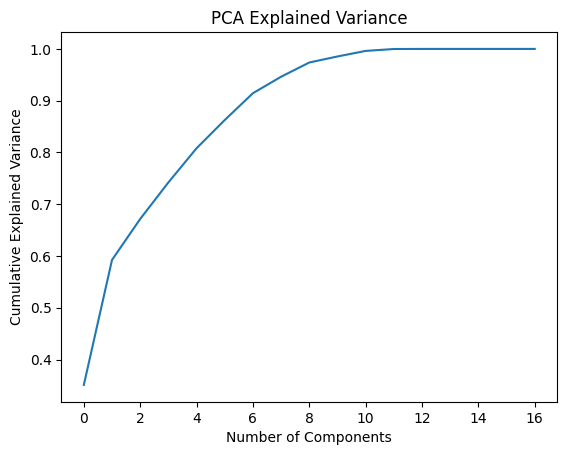

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA
pca = PCA()
pca.fit(df_normalised)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

In [30]:
df_normalised.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6642 entries, ('AAPL', Timestamp('2015-03-17 00:00:00')) to ('MSFT', Timestamp('2023-12-29 00:00:00'))
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Volume             6642 non-null   float64
 1   RSI                6642 non-null   float64
 2   RSI_EWMA           6642 non-null   float64
 3   MACD Line          6642 non-null   float64
 4   ATR                6642 non-null   float64
 5   Middle Band        6642 non-null   float64
 6   Upper Band         6642 non-null   float64
 7   Lower Band         6642 non-null   float64
 8   Signal Line        6642 non-null   float64
 9   Histogram          6642 non-null   float64
 10  RoC                6642 non-null   float64
 11  OBV                6642 non-null   float64
 12  SMA_50             6642 non-null   float64
 13  EMA_50             6642 non-null   float64
 14  GK Volatility      6642 non-null   float6

Next steps:
- We need to focus on actually contriving some sort of model which can predict which stocks to include in portfolio.
- We need to offset the dates so that the current month decides the portfolio makeup for next month

## Constructing an initial portfolio

### Transformations

- Log Transformation for Volume – Prevents massive differences between small and large-cap stocks.
- Z-score for Technical Indicators – Ensures comparability by standardizing mean and variance.
- MinMax for OBV – Since OBV accumulates, MinMax scaling ensures it's relative across stocks.
- No Scaling for Market % Change & Beta – As they are already in a comparable format.

In [32]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Define feature groups based on their characteristics
z_score_features = ['ATR', 'GK Volatility', 'RSI', 'RSI_EWMA', 'MACD Line', 
                    'Signal Line', 'Histogram', 'RoC', 'SMA_50', 'EMA_50', 
                    'Middle Band', 'Upper Band', 'Lower Band']
minmax_features = ['OBV']  # MinMax ensures OBV stays within 0-1
log_features = ['Volume']  # Log transformation for highly skewed data
no_scaling_features = ['Market Pct Change', 'Rolling Beta']

# Apply Standard Scaling (Z-score normalization)
scaler_std = StandardScaler()
df_standardized = pd.DataFrame(scaler_std.fit_transform(df[z_score_features]), 
                               columns=z_score_features, index=df.index)

# Apply MinMax Scaling (0 to 1)
scaler_minmax = MinMaxScaler()
df_minmax = pd.DataFrame(scaler_minmax.fit_transform(df[minmax_features]), 
                         columns=minmax_features, index=df.index)

# Apply Log transformation (log(1 + x) to handle zero values)
df_log = df.copy()
df_log[log_features] = np.log1p(df[log_features])

# Keep unscaled features
df_transformed = df.copy()
df_transformed[z_score_features] = df_standardized
df_transformed[minmax_features] = df_minmax
df_transformed[log_features] = df_log[log_features]
df_transformed[no_scaling_features] = df[no_scaling_features]

df_transformed.head()


Open       High        Low    Close  Adj Close  \
Ticker Date                                                              
AAPL   2015-03-17  31.475000  31.830000  31.412500  31.7600  28.402746   
       2015-03-18  31.750000  32.290001  31.592501  32.1175  28.722458   
       2015-03-19  32.187500  32.312500  31.850000  31.8750  28.505587   
       2015-03-20  32.062500  32.099998  31.290001  31.4750  28.147875   
       2015-03-23  31.780001  31.962500  31.629999  31.8025  28.440754   

                      Volume       RSI  RSI_EWMA  Middle Band  Upper Band  \
Ticker Date                                                                 
AAPL   2015-03-17  19.134083 -0.620845  0.008880    -0.970102   -0.973561   
       2015-03-18  19.380351 -0.655226  0.352911    -0.970137   -0.973618   
       2015-03-19  19.026296 -0.507133  0.013383    -0.970273   -0.973780   
       2015-03-20  19.431483 -0.851446 -0.490676    -0.970788   -0.974334   
       2015-03-23  18.831722 -0.669832 -0.098405    -0.971616   -0.976917   

                   ...  Signal Line  Histogram       ATR       RoC       OBV  \
Ticker Date        ...                                                         
AAPL   2015-03-17  ...    -0.097756  -0.286493 -0.262032 -0.468243  0.860827   
       2015-03-18  ...    -0.113700  -0.195719 -0.253031 -0.491343  0.892007   
       2015-03-19  ...    -0.126124  -0.153702 -0.258210 -0.364651  0.870124   
       2015-03-20  ...    -0.138819  -0.156954 -0.262507 -0.656680  0.837309   
       2015-03-23  ...    -0.149150  -0.128733 -0.256615 -0.519609  0.855322   

                     SMA_50    EMA_50  GK Volatility  Market Pct Change  \
Ticker Date                                                               
AAPL   2015-03-17 -0.988231 -0.984150      -0.680752          -0.003320   
       2015-03-18 -0.986919 -0.983351       0.229012           0.012158   
       2015-03-19 -0.985664 -0.982694      -0.574461          -0.004873   
       2015-03-20 -0.984588 -0.982245       0.267089           0.009013   
       2015-03-23 -0.983675 -0.981664      -0.693484          -0.001746   

                   Rolling Beta  
Ticker Date                      
AAPL   2015-03-17      0.736127  
       2015-03-18      0.848258  
       2015-03-19      0.897576  
       2015-03-20      0.800392  
       2015-03-23      0.763393  

[5 rows x 22 columns]